# Exercise 1 Task 1 Comparing linear and non-linear DR

**Jussi Juvonen**
**27.10.2025**

**Task**: Compare PCA and t-SNE methods by visualizing Bike Sharing Rental dataset.Explore how the different features are shown in the DR components. Build a simple prediction model (for example, MLP or Random Forest) to predict the count of total rental bikes and compare the performance of the model with the different DR techniques.


In [103]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Dataset and problem statement

Using 'day.csv'. The target is 'cnt' total count of bikes rented (registered + casual)
Train a random forest model using:
1. raw preprocessed features (baseline)
2. PCA-transformed features
3. t-SNE-transformed features

Metrics to compare methods: RMSE, MAE and R^2

In [104]:
# Data loading and peek at the data
data_path = os.path.join('data', 'day.csv')
df = pd.read_csv(data_path)

print('Rows, cols:', df.shape)
display(df.head())

Rows, cols: (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Feature selection
Will exclude: 'instant', 'dteday', 'casual' and 'registered'.

Candidate features: season, yr, mnth, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed.

## 

In [105]:
# Preprocessing
all_features = df.columns.tolist()
to_drop = ['instant', 'dteday', 'casual', 'registered', 'cnt']
features = [c for c in all_features if c not in to_drop]

numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = [c for c in features if not c in numeric_features]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])
X_all = df[features].copy()
y_all = df['cnt'].copy()
X_pre = preprocessor.fit_transform(X_all)
print('Preprocessed feature matrix shape:', X_pre.shape)

Numeric features: ['temp', 'atemp', 'hum', 'windspeed']
Categorical features: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Preprocessed feature matrix shape: (731, 36)


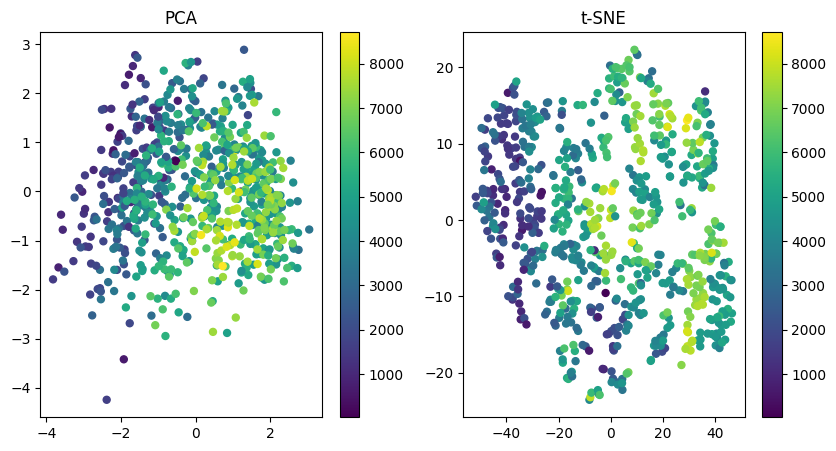

In [106]:
# Visualization of PCA and t-SNE
plt.rcParams["figure.figsize"] = (10, 5)

pca2 = PCA(n_components=2, random_state=0)
X_pca2 = pca2.fit_transform(X_pre)

tsne2 = TSNE(n_components=2, random_state=0, perplexity=30, init='pca')
X_tsne2 = tsne2.fit_transform(X_pre)

fig, axes = plt.subplots(1, 2)
sc0 = axes[0].scatter(X_pca2[:, 0], X_pca2[:, 1], c=y_all, s=25)
axes[0].set_title('PCA')
plt.colorbar(sc0, ax=axes[0])

sc1 = axes[1].scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=y_all, s=25)
axes[1].set_title('t-SNE')
plt.colorbar(sc1, ax=axes[1])
plt.show()

## Visual comparison
**PCA**: The points form a single, fairly compact cloud with a smooth color gradient from low cnt to high cnt. PCA gives a continuous spread of data and does not reveal strongly separated clusters.

**t-SNE**: Here the points show slighly clearer local groupings and a more structured layout. High cnt days appear concentrated in particular regions of the t-SNE map rather than smoothly spread across the entire plot.

In [107]:
# Dataset split and baseline model
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_all, test_size=0.2, random_state=0)

rf = RandomForestRegressor(n_estimators=200, random_state = 0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

def reg_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

metrics_baseline = reg_metrics(y_test, y_pred_rf)
metrics_baseline

{'RMSE': np.float64(673.2369813028006),
 'MAE': 495.2930952380953,
 'R2': 0.8934322096340263}

In [108]:
# PCA for modeling
pca_model = PCA(n_components=3, random_state=0)
x_pca_model = pca_model.fit_transform(X_pre)
print("Explained variance ratio:", pca_model.explained_variance_ratio_)

Xtr_pca, Xte_pca, ytr, yte = train_test_split(x_pca_model, y_all, test_size=0.2, random_state=0)
rf_pca = RandomForestRegressor(n_estimators=200, random_state=0)
rf_pca.fit(Xtr_pca, ytr)
y_pred_pca = rf_pca.predict(Xte_pca)
metrics_pca = reg_metrics(yte, y_pred_pca)
metrics_pca

Explained variance ratio: [0.29264307 0.16314224 0.10670908]


{'RMSE': np.float64(1378.2676564227233),
 'MAE': 1140.9871768707483,
 'R2': 0.5533604652351582}

In [109]:
# t-SNE for modeling
tsne_model = TSNE(n_components=3, random_state=0, perplexity=30)
X_tsne_model = tsne_model.fit_transform(X_pre)

Xtr_tsne, Xte_tsne, ytr2, yte2 = train_test_split(X_tsne_model, y_all, test_size=0.2, random_state=0)
rf_tsne = RandomForestRegressor(n_estimators=200, random_state=0)
rf_tsne.fit(Xtr_tsne, ytr2)
y_pred_tsne = rf_tsne.predict(Xte_tsne)
metrics_tsne = reg_metrics(yte2, y_pred_tsne)
metrics_tsne

{'RMSE': np.float64(991.3861267755846),
 'MAE': 783.7927551020408,
 'R2': 0.7689128974138859}

In [110]:
results = pd.DataFrame([metrics_baseline, metrics_pca, metrics_tsne], index=['Baseline', 'PCA (3 comps)', 't-SNE (3 comps)'])
display(results)

,RMSE,MAE,R2
Baseline,673.236981,495.293095,0.893432
PCA (3 comps),1378.267656,1140.987177,0.553360
t-SNE (3 comps),991.386127,783.792755,0.768913


## Comparison and conclusion

The baseline model trained on the full preprocessed feature set performs best (RMSE ~ 673, R^2 ~ 0.893). The PCA with 3 components loses a lot of predictive signal compared to baseline. Meaning the first 3 components do not capture enough of the information needed for accurate regression. The t-SNE with 3 components performs better than the PCA but still worse than baseline.

The raw preprocessed features outperform both dimensionality-reduced versions in regression. For this dataset and model, compressing the input to three components is too lossy. 